# 1. Instalacja oraz konfiguracja podstawowych paczek

In [1]:
!pip install tensorflow opencv-python matplotlib scikit-learn seaborn pandas


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip list

Package                      Version
---------------------------- -----------
absl-py                      2.1.0
asttokens                    2.4.1
astunparse                   1.6.3
certifi                      2024.6.2
charset-normalizer           3.3.2
comm                         0.2.2
contourpy                    1.2.1
cycler                       0.12.1
debugpy                      1.8.1
decorator                    5.1.1
executing                    2.0.1
flatbuffers                  24.3.25
fonttools                    4.53.0
gast                         0.5.4
google-pasta                 0.2.0
grpcio                       1.64.1
h5py                         3.11.0
idna                         3.7
ipykernel                    6.29.4
ipython                      8.25.0
jedi                         0.19.1
joblib                       1.4.2
jupyter_client               8.6.2
jupyter_core                 5.7.2
keras                        3.3.3
kiwisolver                   1.4.5
li

In [3]:
import tensorflow as tf
import os

2024-06-05 18:28:27.447335: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-05 18:28:27.447705: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 18:28:27.452524: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 18:28:27.514701: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 18:28:28.424578: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [4]:
# Poniższy kod zapobiega  przydzielaniu przez tensorflow całości pamięci GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Weryfikacja, kontrola oraz usunięcie z badania uszkodzonych, wadliwych zdjęć

In [6]:
import cv2
import imghdr

/tmp/ipykernel_143443/4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'data'

In [8]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path) #sprawdzam czy mogę załadować zdjęcie do biblioteki opencv
            tip = imghdr.what(image_path) #sprwadzam czy rozsrzeszenie zdjęcia pokrywa się z akceptowalnymi rozszerzeniami
            if tip not in image_exts:
                print('Zdjęcie posiada nieobsługiwane rozszerzenie {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Wystąpił problem ze zdjęciem {}'.format(image_path))

# 3. Ładowanie danych

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('data') #wywołanie zwróci zestaw danych z wskazanego katalogu, ujednolici, zmniejszy zdjęcia

Found 1208 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator() #konwersja elementów zestawów danych na iterator, pozwoli nam uzyskać dostęp do poszczególnych danych

In [13]:
batch = data_iterator.next() #dostęp do zestawu danych, pobranie pierwszej iteracji

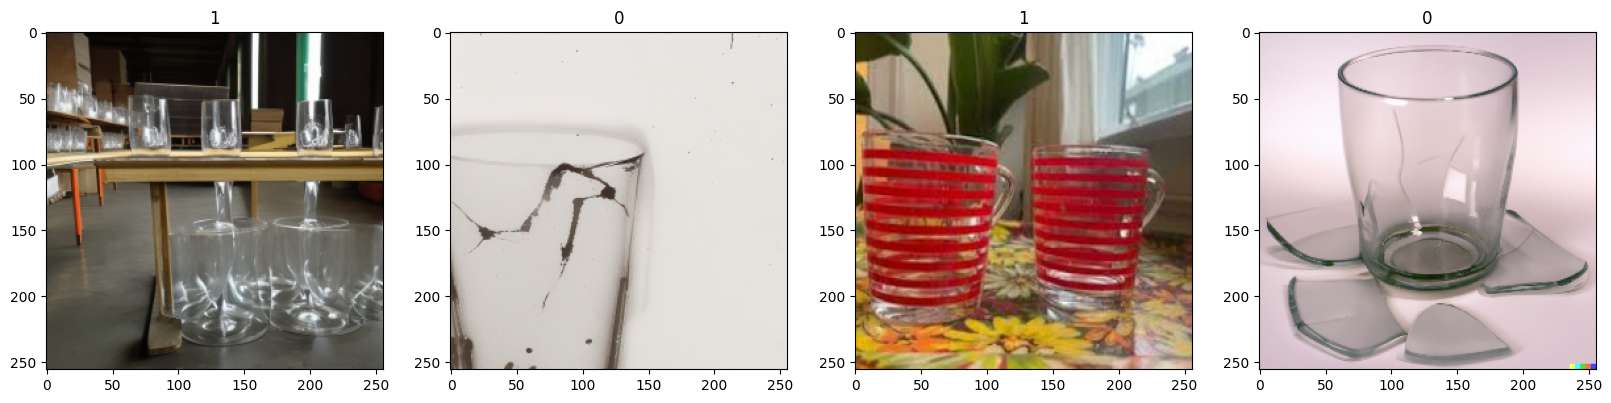

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Wstępne przetwarzanie danych

In [15]:
# przeskalowanie danych, w celu optymalizacji
data = data.map(lambda x,y: (x/255, y)) # funkcja .map umożliwia operacje na całym zestawie danych
data.as_numpy_iterator().next()

(array([[[[0.3127451 , 0.31764707, 0.3627451 ],
          [0.30980393, 0.31666666, 0.3647059 ],
          [0.3127451 , 0.32254902, 0.36666667],
          ...,
          [0.35686275, 0.36568627, 0.39117646],
          [0.35588235, 0.3647059 , 0.39019608],
          [0.35196078, 0.36078432, 0.39117646]],
 
         [[0.32156864, 0.327451  , 0.37254903],
          [0.31764707, 0.33039215, 0.3754902 ],
          [0.32156864, 0.33235294, 0.37941176],
          ...,
          [0.35392156, 0.36078432, 0.38921568],
          [0.3480392 , 0.35784313, 0.38431373],
          [0.34901962, 0.35686275, 0.38431373]],
 
         [[0.3254902 , 0.33529413, 0.38431373],
          [0.32647058, 0.3362745 , 0.38921568],
          [0.32843137, 0.3362745 , 0.38627452],
          ...,
          [0.34705883, 0.35686275, 0.3852941 ],
          [0.34901962, 0.35588235, 0.38333333],
          [0.3480392 , 0.35490197, 0.38333333]],
 
         ...,
 
         [[0.7441176 , 0.72745097, 0.7647059 ],
          [0.72745

In [16]:
train_size = int(len(data)*.7) # część zestawu danych, która będzie odpowiedzalna za trenowanie modelu
val_size = int(len(data)*.2)+1 # część zestwu danych odpowiedzialna za walidacje
test_size = int(len(data)*.1)+1 # część zestawu danych odpowiedzialna za końcowe testy

In [17]:
train_size

26

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 5. Budowa modelu głębokiego uczenia

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [20]:
model = Sequential()

In [21]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

/home/karol/Developments/Image-Classification/imageclassification/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 6. Trenowanie

In [24]:
logdir='logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [26]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 302ms/step - accuracy: 0.6225 - loss: 0.7908 - val_accuracy: 0.7266 - val_loss: 0.5322
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 303ms/step - accuracy: 0.8695 - loss: 0.3067 - val_accuracy: 0.9258 - val_loss: 0.2646
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 8s 304ms/step - accuracy: 0.9264 - loss: 0.2204 - val_accuracy: 0.9141 - val_loss: 0.2480
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 348ms/step - accuracy: 0.9370 - loss: 0.1722 - val_accuracy: 0.9453 - val_loss: 0.1930
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 349ms/step - accuracy: 0.9531 - loss: 0.1426 - val_accuracy: 0.9414 - val_loss: 0.1844
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 354ms/step - accuracy: 0.9642 - loss: 0.0900 - val_accuracy: 0.8984 - val_loss: 0.2402
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 10s 338ms/step - accuracy: 0.9665 - loss: 0.0914 - val_accuracy: 0.9453 - val_loss: 0.1910
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step - accuracy: 0.9835 - loss: 0.0624 - val_accuracy: 

# 7. Badanie wydajności, wykaz strat

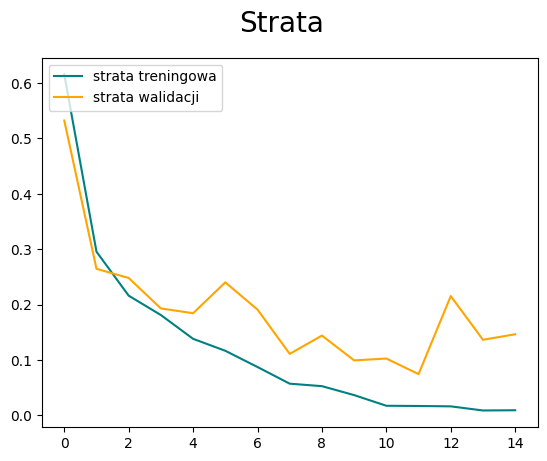

In [27]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='strata treningowa')
plt.plot(hist.history['val_loss'], color='orange', label='strata walidacji')
fig.suptitle('Strata', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 8. Badanie wydajności, wykaz dokładności

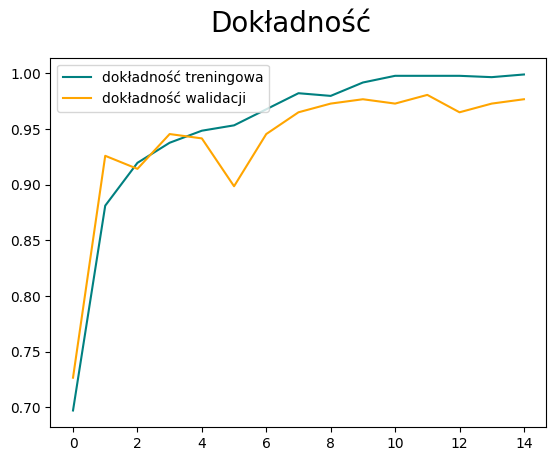

In [28]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='dokładność treningowa')
plt.plot(hist.history['val_accuracy'], color='orange', label='dokładność walidacji')
fig.suptitle('Dokładność', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Test

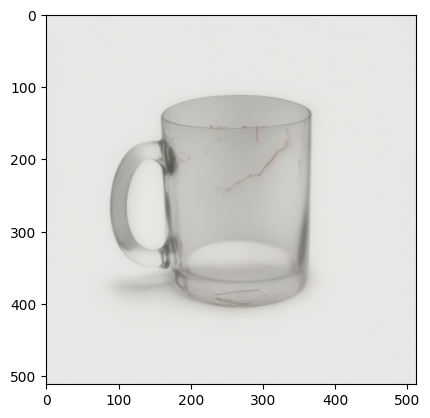

In [29]:
img = cv2.imread('testing/failure_10.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

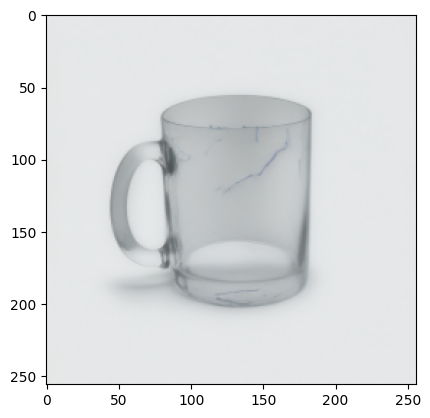

In [30]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [31]:
yhat  = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


In [32]:
yhat

array([[0.00092554]], dtype=float32)

In [33]:
if yhat > 0.5:
    print(f'Wskazany obraz został sklasyfikowany jako część prawidłowa')
else:
    print(f'Wskazany obraz został sklasyfikowany jako część uszkodzona')

Wskazany obraz został sklasyfikowany jako część uszkodzona


# 10. Zapis modelu

In [34]:
from tensorflow.keras.models import load_model

In [35]:
model.save(os.path.join('models', 'imageclassicationversionlive.h5'))

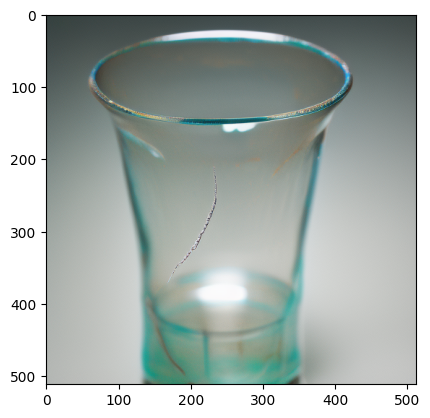

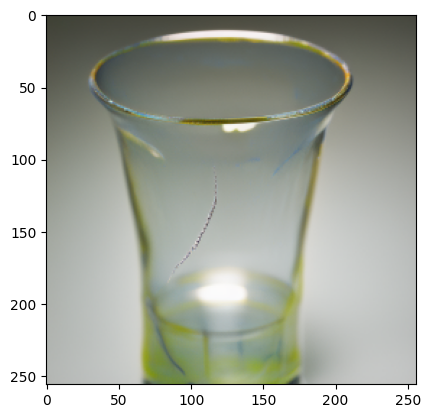

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Wskazany obraz został sklasyfikowany jako część uszkodzona


In [36]:
new_model = load_model(os.path.join('models', 'imageclassicationversionlive.h5'))

img = cv2.imread('testing/failure_4.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize/255, 0))
if yhat > 0.5:
    print(f'Wskazany obraz został sklasyfikowany jako część prawidłowa')
else:
    print(f'Wskazany obraz został sklasyfikowany jako część uszkodzona')

# 11. Ocena modelu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
{'uszkodzony': {'precision': 0.96875, 'recall': 0.96875, 'f1-score': 0.96875, 'support': 64.0}, 'prawidłowy': {'precision': 0.9642857142857143, 'recall': 0.9642857142857143, 'f1-score': 0.9642857142857143, 'support': 56.0}, 'accuracy': 0.9666666666666667, 'macro avg': {'precision': 0.9665178571428572, 'recall': 0.9665178571428572, 'f1-score': 0.9665178571428572, 'support': 120.0}, 'weighted avg': {'precision': 0.9666666666666667, 'recall': 0.9666666666666667, 'f1-score': 0.9666666666666667, 'support': 120.0}}


2024-06-05 18:31:04.471747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


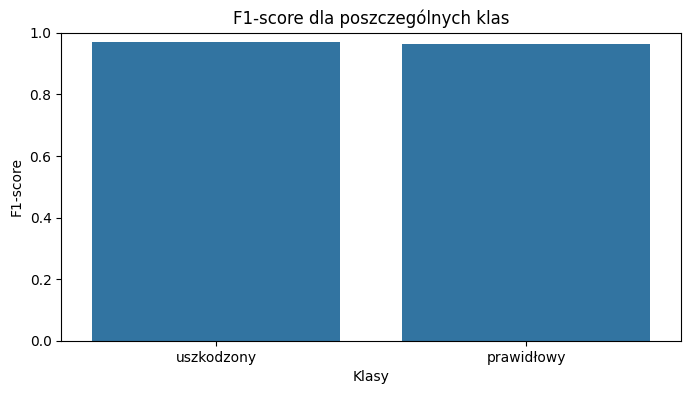

In [37]:
new_model = load_model(os.path.join('models', 'imageclassicationversionlive.h5'))
from sklearn.metrics import classification_report

# Ewaluacja modelu na zbiorze testowym
y_test = []
y_pred = []

for images, labels in test:
    predictions = model.predict(images)
    predictions = np.round(predictions).reshape(-1)
    y_test.extend(labels.numpy())
    y_pred.extend(predictions)

# Obliczenie precyzji, czułości (recall) i F1-score
report = classification_report(y_test, y_pred, target_names=['uszkodzony', 'prawidłowy'], output_dict=True)
print(report)

# Wizualizacja raportu klasyfikacji
import seaborn as sns
import pandas as pd

report_df = pd.DataFrame(report).transpose()
report_df = report_df[:-3]  # Usunięcie zbędnych wierszy (accuracy, macro avg, weighted avg)

plt.figure(figsize=(8, 4))
sns.barplot(x=report_df.index, y='f1-score', data=report_df)
plt.ylim(0, 1)
plt.title('F1-score dla poszczególnych klas')
plt.xlabel('Klasy')
plt.ylabel('F1-score')
plt.show()